![Overlearning](overlearning.png "Overlearning")
![Overlearning full](overlearnfull.png "Overlearning")

# x y

In [111]:
%matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal

In [112]:
with plt.ioff():
    fig, ax = plt.subplots()

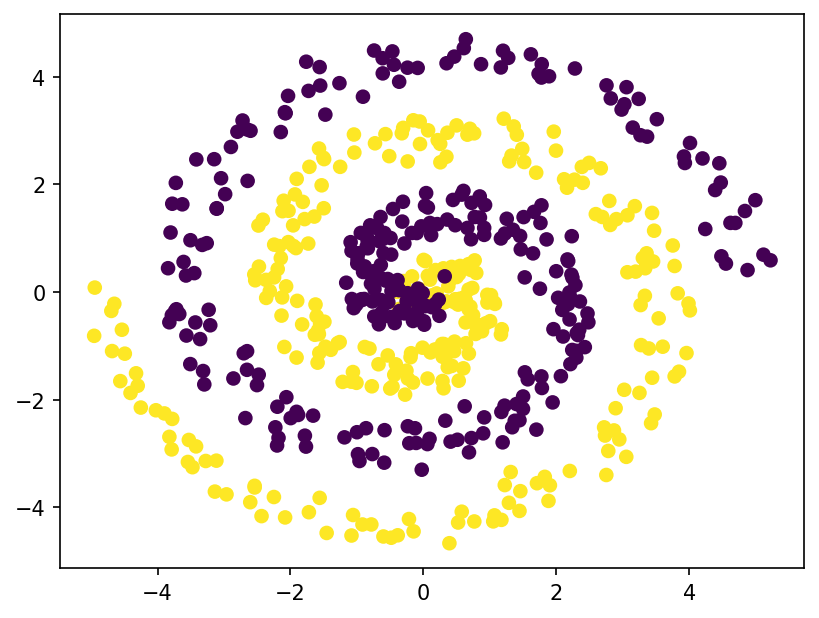

In [119]:
def generate_xor(N: int, noise: int):
    def get_xor_label(x, y):
        return 1 if x * y >= 0 else -1
    
    get_xor_label = np.vectorize(get_xor_label)
    padding = .3
    x = np.random.uniform(-5, 5, N)
    x += np.where(x > 0, padding, -padding)
    y = np.random.uniform(-5, 5, N)
    y += np.where(y > 0, padding, -padding)
    noise_x = np.random.uniform(-5, 5, N) * noise
    noise_y = np.random.uniform(-5, 5, N) * noise
    labels = np.where((x + noise_x) * (y + noise_y) >= 0, 1, -1)
    # labels = get_xor_label(x + noise_x, y + noise_y)
    return x, y, labels

def generate_spiral(N: int, noise: int):
    n = N // 2

    def gen_sigle_spiral(delta_t: int, label: int):
        r = np.arange(n) / n * 5
        t = 1.75 * np.arange(n) / n * 2 * np.pi + delta_t
        x = r * np.sin(t) + np.random.uniform(-1, 1, n) * noise
        y = r * np.cos(t) + np.random.uniform(-1, 1, n) * noise
        return x, y, np.full(n, label)
    
    one = gen_sigle_spiral(0, 1)
    second = gen_sigle_spiral(np.pi, -1)

    x = np.concatenate([one[0], second[0]])
    y = np.concatenate([one[1], second[1]])
    labels = np.concatenate([one[2], second[2]])
    return x, y, labels

def generate_circle(N: int, noise: int):
    radius = 5

    def dist(x, y, center_x, center_y):
        return np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
    dist = np.vectorize(dist)

    def get_circle_label(x, y, center_x, center_y):
        return 1 if dist(x, y, center_x, center_y) <= radius / 2 else -1
    get_circle_label = np.vectorize(get_circle_label)
    
    r = np.concatenate((np.random.uniform(0, radius / 2, N), (np.random.uniform(radius * .7, radius, N))))
    angle = np.random.uniform(0, 2 * np.pi, N * 2)
    x = r * np.sin(angle)
    noise_x = np.random.uniform(-radius, radius, N * 2) * noise
    y = r * np.cos(angle)
    noise_y = np.random.uniform(-radius, radius, N * 2) * noise
    labels = get_circle_label(x + noise_x, y + noise_y, 0, 0)

    return x, y, labels

def generate_two_gauss(N: int, noise: int):
    variance_scale = np.vectorize(lambda x: .5 + 3.5 * (x / .5))
    variance = variance_scale(noise)

    x = np.concatenate((np.random.normal(2, variance, N), np.random.normal(-2, variance, N)))
    y = np.concatenate((np.random.normal(2, variance, N), np.random.normal(-2, variance, N)))
    labels = np.concatenate((np.full(N, 1), np.full(N, -1)))
    return x, y, labels

x, y, labels = generate_spiral(600, .42)
ax.clear()
ax.scatter(x, y, c=labels)
fig

In [4]:
class Perceptron:
    def __init__(self, n: int, activation: Literal["step"] | Literal["sigmoid"] = "step") -> None:
        self.n = n
        self.reset(activation)

    def predict(self, x: np.ndarray) -> int:
        return self.activation(np.dot(self.w, x) + self.bias)

    def forward(self, x: np.ndarray) -> int:
         return np.dot(self.w, x) + self.bias

    def train_theorem(self, training_inputs, reals, learning_rate, epochs):
        for _ in range(epochs):
            for inputs, real in zip(training_inputs, reals):
                prediction = self.forward(inputs)
                # 0 is 1, 1 is 2
                if real == 1 and prediction > 0:
                    self.w -= learning_rate * inputs
                if real == 0 and prediction <= 0:
                    self.w += learning_rate * inputs
    
    def train_gradient_descent(self, training_inputs, reals, learning_rate, epochs):
        for _ in range(epochs):
            for inputs, real in zip(training_inputs, reals):
                sigma = self.predict(inputs)
                gradient = (sigma - real) * sigma * (1 - sigma)
                self.w -= learning_rate * gradient * inputs
                # self.bias -= learning_rate * gradient
    
    def reset(self, activation: Literal["step"] | Literal["sigmoid"] = "step"):
        self.w = np.zeros(self.n)
        self.bias = 0
        match activation:
            case "step":
                self.activation = np.vectorize(lambda x: 1 if x >= 0 else -1)
            case "sigmoid":
                self.activation = np.vectorize(lambda x: 1 / (1 + np.exp(-x)))

In [5]:
def generate_points(N: int, test_percent, noise: int, func):
    global x_train, y_train, labels_train, x_test, y_test, labels_test, train_data, test_data
    test_count = int(N * test_percent)
    x_train, y_train, labels_train = func(N, noise)
    train_data = np.array([x_train, y_train]).T
    x_test, y_test, labels_test = func(test_count, noise)
    test_data = np.array([x_test, y_test]).T

In [93]:
generate_points(800, .2, .2, generate_two_gauss)

In [94]:
ps = Perceptron(2, "sigmoid")
pt = Perceptron(2, "step")

In [95]:
import torch
from torch import nn
from torch.autograd import Variable

model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)
# er_f = nn.HuberLoss()
er_f = nn.BCELoss()
optim = torch.optim.SGD(model.parameters(), lr=1)

In [96]:
%%timeit -n1 -r1
ps.train_gradient_descent(train_data, (labels_train + 1) // 2, .01, 100)

1.87 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [100]:
%%timeit -n1 -r1
pt.train_theorem(train_data, (labels_train - 1) // -2, 1, 100)

191 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [98]:
%%timeit -n1 -r1
x_train =torch.tensor(train_data)
y_train = torch.tensor((labels_train + 1) // 2)
for _ in range(100):
    optim.zero_grad()
    train = Variable(x_train.float(), requires_grad=True)
    target = Variable(y_train.float(), requires_grad=False)
    out = model(train)
    loss = er_f(out.view(-1), target)
    # loss = (out - target).mean()
    loss.backward()
    optim.step()
print(loss)

tensor(0.1813, grad_fn=<BinaryCrossEntropyBackward0>)
28.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Theorem
[160, 160]
[163, 157]
Sigmoid
[160, 160]
[162, 158]
Torch
[160, 160]
[163, 157]
0.940625 0.9375 0.940625


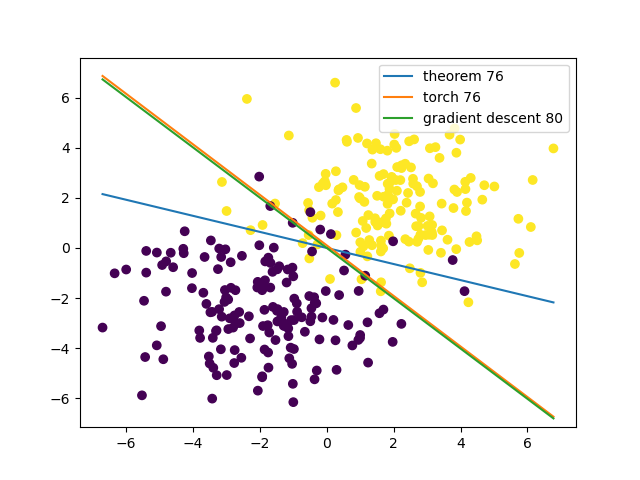

In [124]:
error_sigm = 0
error_torch = 0
error_theorem = 0
right_sigm = 0
right_torch = 0
right_theorem = 0
matr_sigm = [0, 0]
matr_torch = [0, 0]
matr_theorem = [0, 0]
matr_actual = [0, 0]
for data, label in zip(test_data, labels_test):
    ptp = pt.predict(data)
    ptep = model(torch.tensor(data).float())
    # psp = ps.predict(data)
    # error_sigm += (psp - (label + 1) // 2) ** 2
    ptep = 1 if ptep > .5 else -1
    psp = 1 if ps.predict(data) > .5 else -1
    error_torch += (ptep - label) ** 2
    error_sigm += (psp - label) ** 2
    error_theorem += (ptp - label) ** 2
    right_sigm += psp == label
    right_theorem += ptp == label
    right_torch += ptep == label
    matr_actual[int(label + 1) // 2] += 1
    matr_sigm[int(psp + 1) // 2] += 1
    matr_torch[int(ptep + 1) // 2] += 1
    matr_theorem[int(ptp + 1) // 2] += 1
print("Theorem", matr_actual, matr_theorem, sep="\n")
print("Sigmoid", matr_actual, matr_sigm, sep="\n")
print("Torch", matr_actual, matr_torch, sep="\n")
print(right_theorem / len(test_data), right_sigm / len(test_data), right_torch / len(test_data))
x_line = np.linspace(x_test.min(), x_test.max(), 20)
ax.clear()
named = list(model.named_parameters())
w1, w2 = map(float, named[0][1][0])
w0 = float(named[1][1][0])
# print(named, pt.w, ps.w)
ax.plot(x_line, (x_line * -pt.w[0] - pt.bias) / pt.w[1], label=f"theorem {error_theorem}")
ax.plot(x_line, (x_line * -w1 - w0) / w2, label=f"torch {error_torch}")
ax.plot(x_line, (x_line * -ps.w[0] - ps.bias) / ps.w[1], label=f"gradient descent {error_sigm}")
points = ax.scatter(x_test, y_test, c=labels_test)
# points.set_visible(False)
ax.set_ylim(y_test.min() - 1, y_test.max() + 1)
ax.legend()
plt.show(fig)

![Evaluation graph](eval_graph2.png "Evaluation graph")